In [1]:
from pathlib import Path
import os
import pandas as pd
import re
import numpy as np

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [4]:
from transformers import BertTokenizerFast, BertModel, AdamW, get_linear_schedule_with_warmup

In [5]:
from project_path import project_path
project_path(1)

d:\Users\Nicholas\Projects\NLP\long_texts


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, precision_recall_fscore_support

In [7]:
# import from src
import src.models.models as models
import src.models.data_loader as data_loader
import src.models.training as training
import src.features.preprocess as preprocess

In [8]:
import pickle

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [11]:
# if gpu is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
# data directories
proj_dir = Path.cwd().parents[0]
data_raw = Path(proj_dir, 'data', 'raw')

In [13]:
PRE_TRAINED_MODEL_NAME = "D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
data = pd.read_csv(Path(data_raw, 'IMDB Dataset.csv'))

In [15]:
data['tokens'] = data['review'].progress_apply(tokenizer.tokenize)
data['n_tokens'] = data['tokens'].apply(len)

100%|██████████| 50000/50000 [00:51<00:00, 972.08it/s]


In [16]:
# take data with long strings only
data = data.loc[data['n_tokens'] > 700, :]

In [17]:
data['target'] = (data['sentiment'] == 'positive').astype(int)

In [18]:
data.shape

(4024, 5)

In [19]:
# Subsample
# data_sample, _ = train_test_split(data, train_size=0.01, random_state=RANDOM_SEED, shuffle=True, stratify=data['target'])
data_sample = data.copy()
data_sample = data_sample.rename(columns = {'review':'content'})
data_sample = data_sample.drop(['tokens', 'n_tokens'], axis=1)

In [20]:
data_sample.shape

(4024, 3)

#### Train test split

In [21]:
df_train, df_test = train_test_split(
    data_sample, 
    train_size=0.8, 
    random_state=RANDOM_SEED, 
    shuffle=True,
    stratify=data_sample['target'])

In [22]:
df_val, df_test = train_test_split(
    df_test, 
    train_size=0.5, 
    random_state=RANDOM_SEED, 
    shuffle=True, 
    stratify=df_test['target'])

In [23]:
print(df_train.shape, df_val.shape, df_test.shape)

(3219, 3) (402, 3) (403, 3)


In [24]:
print(df_train.target.value_counts(normalize = True))

1    0.541162
0    0.458838
Name: target, dtype: float64


#### Train model

In [25]:
model_dir = "D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1"

In [26]:
model_config = {
    'n_classes':2, 
    'add_linear':[512,256], 
    'attn_bias':False, 
    'freeze_layer_count':8
}

In [27]:
trainer = training.Trainer(model_dir, model_config, epochs=4)

Some weights of the model checkpoint at D:/Users/Nicholas/Projects/BERT_pretrained/biobert-base-cased-v1.1 were not used when initializing HIBERT: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'bert.pooler.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing HIBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HIBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HIBERT were n

In [28]:
for name, param in trainer.model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

In [29]:
trainer.fit(df_train, df_val)

Epoch 1 / 4
--------------------
Batch Train loss: 0.6929     Class 1 prop: 0.4375     ACC: 0.4375     F1: 0.5909     AUC: 0.3058
Batch Train loss: 0.6932     Class 1 prop: 0.5000     ACC: 0.5000     F1: 0.6522     AUC: 0.4896
Batch Train loss: 0.6938     Class 1 prop: 0.5312     ACC: 0.5625     F1: 0.6957     AUC: 0.7066
Batch Train loss: 0.6889     Class 1 prop: 0.4062     ACC: 0.6875     F1: 0.6875     AUC: 0.7274
Batch Train loss: 0.6934     Class 1 prop: 0.5312     ACC: 0.7500     F1: 0.8000     AUC: 0.8648
Batch Train loss: 0.6938     Class 1 prop: 0.5312     ACC: 0.6875     F1: 0.7619     AUC: 0.7754
Batch Train loss: 0.6932     Class 1 prop: 0.5312     ACC: 0.7812     F1: 0.7742     AUC: 0.7791
Batch Train loss: 0.6941     Class 1 prop: 0.5625     ACC: 0.7188     F1: 0.7907     AUC: 0.7931
Batch Train loss: 0.6937     Class 1 prop: 0.5625     ACC: 0.6250     F1: 0.7391     AUC: 0.7620
Batch Train loss: 0.6914     Class 1 prop: 0.5000     ACC: 0.7188     F1: 0.7273     AUC: 0.73

#### plot history

In [30]:
history = trainer.history

In [31]:
epochs = len(history['train_loss'])

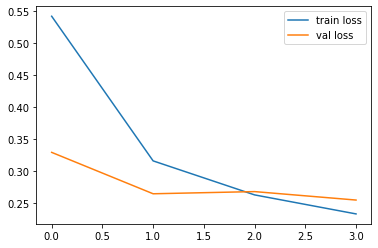

In [32]:
plt.plot(list(range(epochs)), history['train_loss'], label = 'train loss')
plt.plot(list(range(epochs)), history['val_loss'], label = 'val loss')
plt.legend()

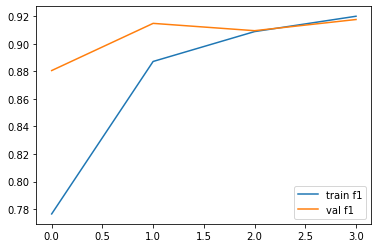

In [33]:
plt.plot(list(range(epochs)), history['train_f1'], label = 'train f1')
plt.plot(list(range(epochs)), history['val_f1'], label = 'val f1')
plt.legend()

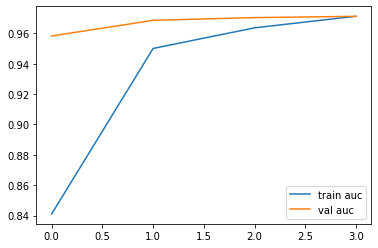

In [34]:
plt.plot(list(range(epochs)), history['train_auc'], label = 'train auc')
plt.plot(list(range(epochs)), history['val_auc'], label = 'val auc')
plt.legend()

#### make predictions

In [35]:
predictor = training.Predictor(model_dir='trained_model')

In [36]:
pred_dict = predictor.predict(df_test.head())

In [37]:
pred_dict

{'target': [1, 1, 0, 1, 0],
 'pred_proba': [0.979252278804779,
  0.12515249848365784,
  0.1037633940577507,
  0.9771537780761719,
  0.04255690053105354],
 'pred': [1, 0, 0, 1, 0],
 'attn_wts': [array([0.00043046, 0.00056061, 0.00041711, ..., 0.00117454, 0.00120941,
         0.00127265], dtype=float32),
  array([0.00055018, 0.00090614, 0.0005852 , ..., 0.00055899, 0.00057383,
         0.00247943], dtype=float32),
  array([0.00115516, 0.00071802, 0.00069747, ..., 0.00045809, 0.000503  ,
         0.0005253 ], dtype=float32),
  array([0.00165872, 0.0014742 , 0.00137989, ..., 0.00048526, 0.00046818,
         0.00049013], dtype=float32),
  array([0.00036188, 0.00027478, 0.00023842, ..., 0.00118156, 0.00160002,
         0.00124653], dtype=float32)],
 'input_ids': [array([ 101, 1122, 1156, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1155, 1268, ...,    0,    0,    0], dtype=int64),
  array([ 101, 2903, 1142, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1198, 1400, ...,    0,  

In [38]:
df_test_ = df_test.drop('target', axis=1)

In [39]:
pred_dict_ = predictor.predict(df_test_.head())

In [40]:
pred_dict_

{'target': [nan, nan, nan, nan, nan],
 'pred_proba': [0.979252278804779,
  0.12515249848365784,
  0.1037633940577507,
  0.9771537780761719,
  0.04255690053105354],
 'pred': [1, 0, 0, 1, 0],
 'attn_wts': [array([0.00043046, 0.00056061, 0.00041711, ..., 0.00117454, 0.00120941,
         0.00127265], dtype=float32),
  array([0.00055018, 0.00090614, 0.0005852 , ..., 0.00055899, 0.00057383,
         0.00247943], dtype=float32),
  array([0.00115516, 0.00071802, 0.00069747, ..., 0.00045809, 0.000503  ,
         0.0005253 ], dtype=float32),
  array([0.00165872, 0.0014742 , 0.00137989, ..., 0.00048526, 0.00046818,
         0.00049013], dtype=float32),
  array([0.00036188, 0.00027478, 0.00023842, ..., 0.00118156, 0.00160002,
         0.00124653], dtype=float32)],
 'input_ids': [array([ 101, 1122, 1156, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1155, 1268, ...,    0,    0,    0], dtype=int64),
  array([ 101, 2903, 1142, ...,    0,    0,    0], dtype=int64),
  array([ 101, 1198, 1400, ..